# Variational Auto-encoder (PyTorch)
Create a generative model for MNIST images.
<br>Reference Link: [Variational Autoencoders Explained](http://kvfrans.com/variational-autoencoders-explained/)

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r

In [3]:
class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

In [4]:
class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))

![Deconvolution](http://kvfrans.com/content/images/2016/08/dat.jpg)
![Autoencode](http://kvfrans.com/content/images/2016/08/autoenc.jpg)

In [5]:
class VAE(torch.nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)

Variational Autoencoder(VAE)는 두가지 요소에 대한 정확도를 학습합니다.
- 이미지를 얼마나 정확하게 Generate했는가
- Latent variable이 unit gaussian에 얼마나 근접했는가
    - 이를 측정하기 위해 KL-divergence를 사용합니다
    - 여기서는 실제 값의 모든 vector를 사용하는 대신 평균(mean)과 분포(standard deviation) vector만을 사용합니다.

위 두 요소 사이에는 trade-off가 있습니다.

```code
generation_loss = mean(square(generated_image - real_image))  
latent_loss = KL-Divergence(latent_variable, unit_gaussian)  
loss = generation_loss + latent_loss
```

그림으로 나타내면 아래와 같습니다.
![VAE](http://kvfrans.com/content/images/2016/08/vae.jpg)

In [6]:
def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)

In [7]:
input_dim = 28 * 28
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()])
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

print('Number of samples: ', len(mnist))

encoder = Encoder(input_dim, 100, 100)
decoder = Decoder(8, 100, input_dim)
vae = VAE(encoder, decoder)

criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.0001)
l = None

Number of samples:  60000


In [8]:
for epoch in range(100):
    for i, data in enumerate(dataloader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
        optimizer.zero_grad()
        dec = vae(inputs)
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec, inputs) + ll
        loss.backward()
        optimizer.step()
        l = loss.item()    # loss.data[0] will produce warning in PyTorch 0.4
    print(epoch, l)

0 0.0663687139749527
1 0.0690300241112709
2 0.06314890831708908
3 0.0687660351395607
4 0.0712401419878006
5 0.06650761514902115
6 0.06941360235214233
7 0.06615210324525833
8 0.0631953626871109
9 0.06980690360069275
10 0.06972867250442505
11 0.0643949955701828
12 0.062161222100257874
13 0.06403818726539612
14 0.06886661797761917
15 0.06459414958953857
16 0.0682990700006485
17 0.0761084035038948
18 0.06664256006479263
19 0.06773415952920914
20 0.06767349690198898
21 0.06547828018665314
22 0.06525144726037979
23 0.06317349523305893
24 0.06219231337308884
25 0.06615196168422699
26 0.07227176427841187
27 0.062339406460523605
28 0.07176733016967773
29 0.06655406206846237
30 0.06663045287132263
31 0.06796737015247345
32 0.06757582724094391
33 0.0661088228225708
34 0.06294684112071991
35 0.0647888258099556
36 0.06897665560245514
37 0.06624607741832733
38 0.07474660128355026
39 0.06834234297275543
40 0.06798367947340012
41 0.0684843510389328
42 0.06374235451221466
43 0.06740977615118027
44 0.06

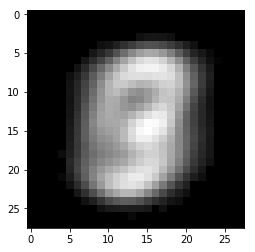

In [10]:
plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)